# Initial Project Analysis Pipeline
## July 2023


Brief thoughts on pipeline here:
- Gather all data
- Identify first base recieves that are outs and that are not outs, and those that are just bad throws, but not recieved (like that play 203)

    - Other considerations here:
        - I might need to filter out throws that start too close to first for my method?
        - vertical angle?
        - velos?

- Build a probability model for this
- Make some calibration plots


From there, the path might diverge a little bit
- run expectancy?
- Fields Above Average?



### TODO:
- throw in batter x,y, velo? 
- my model grabber needs to pick the throw before whatever event!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Prep Data

### Find throws to first that are just so bad the first baseman didn't catch it

- 203 in 1903_01_TeamNE_TeamA2 is the cannonical example

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


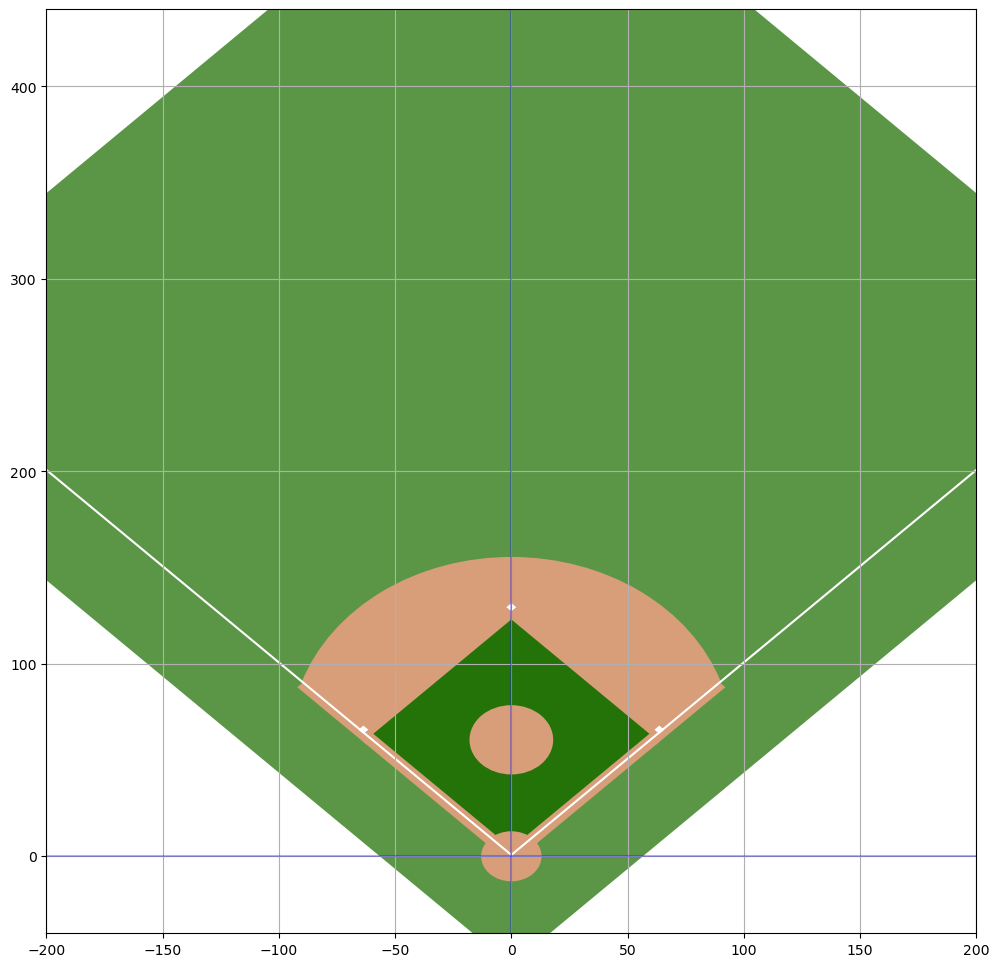

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [4]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()


game_events_1903_01.head(5)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y
1,1903_01_TeamNE_TeamA2,1,1,1,19199,1,1,pitch,2.0,ball acquired,19661.0,NaN,NaN,NaN,NaN,NaN,NaN,89.076422,NaN,NaN
2,1903_01_TeamNE_TeamA2,1,1,1,19661,2,2,ball acquired,5.0,end of play,19661.0,1.0,pitch,19199.0,NaN,NaN,NaN,89.076422,NaN,NaN
3,1903_01_TeamNE_TeamA2,1,1,1,19661,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,19661.0,NaN,NaN,NaN,89.076422,NaN,NaN
4,1903_01_TeamNE_TeamA2,2,1,2,29858,1,1,pitch,2.0,ball acquired,30320.0,NaN,NaN,NaN,NaN,NaN,NaN,89.114508,NaN,NaN
5,1903_01_TeamNE_TeamA2,2,1,2,30320,2,2,ball acquired,5.0,end of play,30320.0,1.0,pitch,29858.0,NaN,NaN,NaN,89.114508,NaN,NaN


### Get all throws 

In [5]:
throws = game_events_1903_01.loc[game_events_1903_01["event"] == "throw (ball-in-play)", :]
throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y
33,1903_01_TeamNE_TeamA2,10,2,10,179315,6,3,throw (ball-in-play),2.0,ball acquired,179942.0,2.0,ball acquired,178820.0,40.970997,2.162650,63.020815,76.027923,-56.0139,116.8362
35,1903_01_TeamNE_TeamA2,10,2,10,180536,4,3,throw (ball-in-play),2.0,ball acquired,181361.0,2.0,ball acquired,179942.0,1.962933,2.041084,73.227697,47.089984,0.6681,129.3444
66,1903_01_TeamNE_TeamA2,18,4,18,461301,6,3,throw (ball-in-play),2.0,ball acquired,462225.0,2.0,ball acquired,460212.0,2.714353,3.179570,75.066867,45.904246,-1.5081,145.3005
96,1903_01_TeamNE_TeamA2,25,6,25,616962,7,3,throw (ball-in-play),2.0,ball acquired,618777.0,2.0,ball acquired,615543.0,24.879819,17.746083,56.316458,15.056423,-141.4197,234.9465
110,1903_01_TeamNE_TeamA2,28,7,28,714180,6,3,throw (ball-in-play),2.0,ball acquired,714840.0,2.0,ball acquired,713652.0,59.036393,1.662283,35.729095,53.972154,-28.8978,113.7537
138,1903_01_TeamNE_TeamA2,36,8,36,1016790,9,3,throw (ball-in-play),16.0,ball bounce,1018407.0,2.0,ball acquired,1013886.0,19.781893,7.826560,59.497665,21.427403,36.3627,250.9065
150,1903_01_TeamNE_TeamA2,38,9,38,1094175,5,3,throw (ball-in-play),2.0,ball acquired,1095198.0,2.0,ball acquired,1092459.0,1.108531,1.218903,84.224138,60.608922,-59.9457,81.2073
216,1903_01_TeamNE_TeamA2,58,13,58,1618117,6,3,throw (ball-in-play),2.0,ball acquired,1619239.0,2.0,ball acquired,1616896.0,2.358087,4.034777,72.686062,51.954068,-39.4440,125.9001
256,1903_01_TeamNE_TeamA2,69,16,69,2010520,8,3,throw (ball-in-play),2.0,ball acquired,2012434.0,2.0,ball acquired,2009662.0,34.124119,18.471341,51.546902,5.490810,54.4110,239.0079
273,1903_01_TeamNE_TeamA2,73,17,73,2191492,5,3,throw (ball-in-play),2.0,ball acquired,2192317.0,2.0,ball acquired,2190634.0,48.628686,2.317024,73.219675,55.609675,-57.3255,61.6473


#### Find all of the throws to first that are outs

In [ ]:
trusted_first_base_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] >= 1)
                                                                     &\
                                                         (game_info_1903_01["trust_this_half"] == 1), "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_outs_plays

In [ ]:
game_events_1903_01.loc[(game_events_1903_01["event"] == "throw (ball-in-play)") &\
                        (game_events_1903_01["play_per_game"].isin(trusted_first_base_outs_plays.values)), :]

In [ ]:
bf_1903_01.clear_plot()

play_id = bf_1903_01.game_obj.get_pid_from_ppg(224)

#bf_1903_01.plot_all_components(play_id=play_id)
#bf_1903_01.fig
bf_1903_01.create_gif(play_id=play_id, tag="--1-3 out")

In [ ]:
trusted_first_base_not_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] == 0) 
                                                                     #& (game_info_1903_01["trust_this_half"] == 1)
                                                                     ,
                                                                     "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_not_outs_plays

In [ ]:
throws.loc[throws["xy_throw_angle"] < 7]

In [ ]:
## HMM can I use the game info here?
# I think I can use just the trusted plays?
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[throws["xy_throw_angle"] < 7, "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] == 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]


In [ ]:
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[(throws["xy_throw_angle"] < 7) &
                                                        (throws["player_position"].isin([1, 2, 4, 5, 6]))
                                                        , "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] > 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]

In [ ]:
# NEED TO PICK THE CORRECT THROW -- do this by picking the min xy_angle?
# also need to make sure that they aren't back picks


In [ ]:
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
player_pos_1903_01.head(3)

In [ ]:
ball_pos_1903_01 = bf_1903_01.game_obj.new_ball_pos.copy()
ball_pos_1903_01.head(3)

In [ ]:
temp_throw = throws[throws["play_id"] == 203]
temp_throw

In [ ]:
# get batter dist to first at time of throw!
ball_pos_df = ball_pos_1903_01

timestamp = temp_throw["timestamp"].values[0]

# find the x, y pos of the batter at the time of throw
# player pos and velo
batter_data = player_pos_1903_01.loc[(player_pos_1903_01["timestamp"] == timestamp) &\
                                     (player_pos_1903_01["player_position"] == 10)
                                     , ["play_id", "field_x", "field_y", "velo_x", "velo_y"]]


target_point = np.array([63.63961031, 63.63961031])

batter_pos_at_throw = batter_data[["field_x", "field_y"]].values[0]

batter_vect_to_first = (target_point - batter_pos_at_throw)

# find the distance of the batter to first
batter_dist_to_first = np.sqrt(batter_vect_to_first.dot(batter_vect_to_first))

# batter_dist_to_first

"""
# get batter velo over the whole time before the throw!
# velo is harder because I don't necessarily know when the batter starts to go
# its not at the pitch, it could be when the ball is hit, but the ball isn't
# always hit! Maybe the first event after the pitch?

batter_dist_from_home = np.sqrt(batter_pos_at_throw.dot(batter_pos_at_throw))

game_events_1903_01.loc[
    game_events_1903_01["play_id"] == temp_throw["play_id"].values[0]
].groupby("play_id").first()["timestamp"].values[0]
"""

In [ ]:
game_events_1903_01.loc[
    game_events_1903_01["play_id"] == temp_throw["play_id"].values[0]
].groupby("play_id").first()["timestamp"].values[0]

In [ ]:
temp_throw.timestamp

In [ ]:
# turn the 

In [ ]:
# player pos and velo
player_pos_1903_01.loc[(player_pos_1903_01["timestamp"] == timestamp) &\
                       (player_pos_1903_01["player_position"] == temp_throw["player_position"].values[0])
                       , ["play_id", "field_x", "field_y", "velo_x", "velo_y"]]

In [ ]:
# calculate the angle of elevation
# I think this is literally just PI - arccos(z_comp_of_velo) 

ball_pos_df = ball_pos_1903_01

timestamp = temp_throw["timestamp"].values[0]

buffer_ms = -10
snapshot_time = 250

# find when the ball is in the air with a buffer or not
ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                   (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                   # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                   :
                                  ] 

In [ ]:
throw_velo_vect = ball_in_air_df[["ball_position_x", "ball_position_y", "ball_position_z"]].iloc[-1].values \
    - ball_in_air_df[["ball_position_x", "ball_position_y", "ball_position_z"]].iloc[0].values
#throw_velo_vect

ball_flight_time_sec = (ball_in_air_df["timestamp"].iloc[-1] - ball_in_air_df["timestamp"].iloc[0])/1000

unit_z_vect = np.array([0, 0, 1])


elevation_angle_rad = (np.pi/2 - np.arccos(throw_velo_vect.dot(unit_z_vect) / np.sqrt(throw_velo_vect.dot(throw_velo_vect))))
elevation_angle_deg = elevation_angle_rad * 180 / np.pi
elevation_angle_deg

# this is feet per (ball_flight_time) * 1.467 [fps to mph]
np.sqrt(throw_velo_vect.dot(throw_velo_vect)) / ball_flight_time_sec


In [ ]:
def compute_throw_angle(a, target_point = np.array([63.63961031, 63.63961031])):
    """
    target_point defaults to first base
    
    """
    
    # TODO: do I NEED THE angle of inclination even here?
    # I think not for now!
        
    # make a vector from the first point to the target point
    xy_vect_to_target = target_point - a[["ball_position_x", "ball_position_y"]].iloc[0].values

    # scale it to be a unit vector
    unit_xy_vect_to_target = xy_vect_to_target / np.sqrt(xy_vect_to_target.dot(xy_vect_to_target))
    
    # Maybe the whole window so we don't get noise?
    throw_velo_xy_vect = a[["ball_position_x", "ball_position_y"]].iloc[-1].values \
        - a[["ball_position_x", "ball_position_y"]].iloc[0].values
    
    # the other one is a unit vect, so we don't need to divide here
    xy_angle_to_first_rad = np.arccos(throw_velo_xy_vect.dot(unit_xy_vect_to_target) / np.sqrt(throw_velo_xy_vect.dot(throw_velo_xy_vect)))
    
    xy_angle_to_first_deg = xy_angle_to_first_rad * 180 / np.pi

    # hmm there are some times where you might want to miss the bag -- e.g. throws from catcher! 

    return xy_angle_to_first_deg
    
    

In [ ]:
def fill_throw_angle(timestamp, ball_pos_df, target_point = np.array([63.63961031, 63.63961031])): 
    """
    
    """
    
    ball_pos_df = ball_pos_df.copy()
    
    buffer_ms = -10
    snapshot_time = 250

    # find when the ball is in the air with a buffer or not
    ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                       (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                       # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                       :
                                      ] 
    
    # print(ball_in_air_df["play_id"].describe())
    angle = compute_throw_angle(ball_in_air_df, target_point)
    
    return angle
    
    
    

In [ ]:
# Find plays where there is a throw and no ball acquired before the end of the play
# these are throwing errors, but we can't guarantee that they are thrown to first yet

game_events_1903_01.loc[(game_events_1903_01["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                        (game_events_1903_01["next_event"] == "end of play")
                        # I have the angle already!
                        # need another condition that says this is going to first?
                        
                        , :]

In [ ]:
throws["xy_throw_angle"] = np.nan
throws["xy_throw_angle"] = throws.apply(lambda row: fill_throw_angle(row["timestamp"], ball_pos_1903_01), axis = 1)

In [ ]:
throws["xy_throw_angle"].loc[(throws["player_position"].isin([1, 2, 4, 5, 6]))].plot(kind="hist")

In [ ]:
# because this is like the cosine similarity to each other, we don't have a sense for which side of the bag the throw went to
# want infielder throws only
# note that higher angles throws are either throws behind a runner (usually in the [5, 10] range)
# or they are bad throws?

throws.loc[(throws["xy_throw_angle"] > 100) & (throws["player_position"].isin([1, 2, 4, 5, 6]) ), :]

In [ ]:
# look at all of these with the outs

In [ ]:
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()

In [ ]:
game_info_1903_01.loc[game_info_1903_01["play_per_game"] == 124]

game_info_1903_01.loc[(game_info_1903_01["inning"] == 4) & (game_info_1903_01["top_bottom_inning"] == "Top")]

In [ ]:
bf_1903_01.clear_plot()

play_id = 25 # throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--4-6-3 dp")

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].describe()

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].plot(kind="hist", alpha=0.5)

### Find all throws to first!

## Collect the plays into a csv, will use this to compute features later

In [7]:
all_games = get_all_game_strs()

Gathered a list of 97 games


In [8]:
# TODO! This should acutally be the throw right before this event!


total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0
total_throws_out_of_play = 0
total_trusted_double_plays = 0

model_dataset = pd.DataFrame()

cols_to_save = ["game_str", "play_id", "play_per_game",
                "xy_throw_angle", "elevation_throw_angle",
                "throw_velo", "batter_dist_to_first",
                "thrower_x","thrower_y",
                "type"]


for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :]
    
    trusted_outs["type"] = "trusted_out"
    model_dataset = pd.concat([model_dataset, trusted_outs[["game_str", "play_per_game", "type"]]])
    trusted_outs = trusted_outs.shape[0]
    
        
    trusted_successful_first_base_outs = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    trusted_successful_first_base_outs["type"] = "trusted_first_base_out"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs[cols_to_save]])
    trusted_successful_first_base_outs = trusted_successful_first_base_outs.shape[0]
    
    trusted_unsuccessful_first_base_outs = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 0) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    trusted_unsuccessful_first_base_outs["type"] = "trusted_first_base_not_out"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs[cols_to_save]])
    trusted_unsuccessful_first_base_outs = trusted_unsuccessful_first_base_outs.shape[0]
    
    trusted_double_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 2) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    trusted_double_plays["type"] = "trusted_double_play"
    model_dataset = pd.concat([model_dataset, trusted_double_plays[cols_to_save]])
    trusted_double_plays = trusted_double_plays.shape[0]

    
    # TODO: Add overthrows here!
    throws_out_of_play = g_game_events.loc[(g_game_events["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                                           (g_game_events["next_event"] == "end of play") &\
                                           (g_game_events["xy_throw_angle"] <= 10)
                                           # I have the angle already!
                                           # need another condition that says this is going to first?
                                           , :]
    
    throws_out_of_play["type"] = "throws_to_end_play"
    model_dataset = pd.concat([model_dataset, throws_out_of_play[cols_to_save]])
    throws_out_of_play = throws_out_of_play.shape[0]    
    
    print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
        trusted_outs,
        trusted_successful_first_base_outs,
        trusted_unsuccessful_first_base_outs,
        trusted_double_plays,
        throws_out_of_play
    ))
    
    
    total_trusted_outs += trusted_outs
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs
    total_trusted_double_plays += trusted_double_plays
    total_throws_out_of_play += throws_out_of_play
    
    plt.close()

    
print("---------------")    

print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
    total_trusted_outs,
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_trusted_double_plays,
    total_throws_out_of_play
    
))


Which game: 1903_01_TeamNE_TeamA2
Distance between ball and player is large on average, should maybe clean up 12.199183415462679
31 trusted outs in this game 
10 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_16_TeamNI_TeamA3
41 trusted outs in this game 
12 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_02_TeamMG_TeamA3
33 trusted outs in this game 
11 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_08_TeamNJ_TeamB
39 trusted outs in this game 
16 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_08_TeamKL_TeamB
12 trusted outs in this game 
5 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_23_TeamNA_TeamA1
32 t

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
4 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_17_TeamNI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


28 trusted outs in this game 
11 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_27_TeamNK_TeamB
36 trusted outs in this game 
6 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1901_12_TeamLJ_TeamB
12 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_09_TeamKK_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_01_TeamLG_TeamA3
9 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_03_TeamKJ_TeamB
Distance between ball and player is large on average, should maybe clean up 6.403561421830762
6 trusted outs in this game 
0 trusted first b

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
3 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_32_TeamNB_TeamA1
33 trusted outs in this game 
14 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_07_TeamLK_TeamB
9 trusted outs in this game 
1 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_23_TeamMA_TeamA1
31 trusted outs in this game 
9 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_15_TeamMK_TeamB
39 trusted outs in this game 
13 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_04_TeamML_TeamB
31 trusted outs in this game 
8 trusted first base outs	5 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


41 trusted outs in this game 
13 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_19_TeamNL_TeamB
37 trusted outs in this game 
12 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_02_TeamLG_TeamA3
5 trusted outs in this game 
3 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_31_TeamNB_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
10 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_09_TeamLK_TeamB
9 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_10_TeamMI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
0 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_02_TeamNE_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


29 trusted outs in this game 
12 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_26_TeamMC_TeamA1
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_26_TeamNK_TeamB
32 trusted outs in this game 
8 trusted first base outs	3 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_24_TeamMA_TeamA1
36 trusted outs in this game 
16 trusted first base outs	5 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_01_TeamMG_TeamA3
24 trusted outs in this game 
6 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_18_TeamLH_TeamA3
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
2 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_30_TeamNB_TeamA1
36 trusted outs in this game 
16 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_11_TeamMI_TeamA3
39 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_05_TeamND_TeamA2
Distance between ball and player is large on average, should maybe clean up 14.67974023000007
35 trusted outs in this game 
7 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_26_TeamNH_TeamA3
34 trusted outs in this game 
10 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_15_TeamNG_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
13 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1900_04_TeamKK_TeamB
12 trusted outs in this game 
2 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_20_TeamNL_TeamB
37 trusted outs in this game 
16 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_06_TeamML_TeamB
23 trusted outs in this game 
7 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_18_TeamNI_TeamA3
46 trusted outs in this game 
18 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_09_TeamMJ_TeamB
47 trusted outs in this game 
6 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encount

36 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_29_TeamMF_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


16 trusted outs in this game 
7 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_28_TeamMC_TeamA1
15 trusted outs in this game 
4 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_04_TeamLI_TeamA3
19 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_28_TeamNF_TeamA2
48 trusted outs in this game 
8 trusted first base outs	3 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_16_TeamLH_TeamA3
12 trusted outs in this game 
0 trusted first base outs	3 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_25_TeamMH_TeamA3
41 trusted outs in this game 
10 trusted first base outs	5 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end pla

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


21 trusted outs in this game 
10 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_17_TeamMB_TeamA1
15 trusted outs in this game 
3 trusted first base outs	5 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_08_TeamMJ_TeamB
40 trusted outs in this game 
15 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_10_TeamNJ_TeamB
38 trusted outs in this game 
13 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_29_TeamNF_TeamA2
41 trusted outs in this game 
13 trusted first base outs	3 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1901_15_TeamLL_TeamB
Distance between ball and player is large on average, should maybe clean up 5.3524560073690175
15 trusted outs in this game 
2 trusted

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1163: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


35 trusted outs in this game 
11 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1901_11_TeamLJ_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_31_TeamMF_TeamA2
42 trusted outs in this game 
9 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

---------------
2219 trusted outs in this game 
654 trusted first base outs	134 trusted_first_base_not_outs --- 	 trusted double plays 56 	 throws to end play 0



In [9]:
# Write the model_dataset 
# model_dataset.to_csv("model_dataset.csv")

## See some of the overthrows?

In [12]:
model_dataset = pd.read_csv("model_dataset.csv", index_col=0)

In [14]:
model_dataset.loc[model_dataset["type"] == "trusted_first_base_out"]

,game_str,play_per_game,type,play_id,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y
36,1903_01_TeamNE_TeamA2,10,trusted_first_base_out,10.0,NaN,NaN,NaN,23.812321,NaN,NaN
182,1903_01_TeamNE_TeamA2,48,trusted_first_base_out,48.0,NaN,NaN,NaN,5.415868,NaN,NaN
217,1903_01_TeamNE_TeamA2,58,trusted_first_base_out,58.0,NaN,NaN,NaN,23.276346,NaN,NaN
456,1903_01_TeamNE_TeamA2,119,trusted_first_base_out,119.0,NaN,NaN,NaN,27.688541,NaN,NaN
485,1903_01_TeamNE_TeamA2,124,trusted_first_base_out,124.0,NaN,NaN,NaN,20.593925,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
647,1902_31_TeamMF_TeamA2,188,trusted_first_base_out,188.0,NaN,NaN,NaN,13.423730,NaN,NaN
687,1902_31_TeamMF_TeamA2,198,trusted_first_base_out,198.0,NaN,NaN,NaN,8.204738,NaN,NaN
708,1902_31_TeamMF_TeamA2,203,trusted_first_base_out,203.0,NaN,NaN,NaN,24.394698,NaN,NaN
853,1902_31_TeamMF_TeamA2,245,trusted_first_base_out,245.0,NaN,NaN,NaN,17.202228,NaN,NaN


In [15]:
bf = Baseball_Field("1903_06_TeamND_TeamA2")

Distance between ball and player is large on average, should maybe clean up 15.614163808346984


In [16]:
g_game_events = bf.game_obj.game_events_df.copy()

In [17]:
throws = g_game_events.loc[g_game_events["event"] == "throw (ball-in-play)", :]

throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y
41,1903_06_TeamND_TeamA2,12,3,12,228274,8,3,throw (ball-in-play),2.0,ball acquired,229624.0,2.0,ball acquired,227324.0,10.385907,6.244960,72.976509,31.150939,-65.4420,238.6455
52,1903_06_TeamND_TeamA2,15,4,15,300774,2,3,throw (ball-in-play),2.0,ball acquired,302024.0,2.0,ball acquired,300074.0,48.408620,3.093778,75.778152,92.848374,-0.2481,-3.7899
64,1903_06_TeamND_TeamA2,17,5,17,463274,6,3,throw (ball-in-play),2.0,ball acquired,464124.0,2.0,ball acquired,462524.0,1.224602,2.997335,69.148599,38.644448,-15.1536,105.5373
78,1903_06_TeamND_TeamA2,19,6,19,530924,7,3,throw (ball-in-play),16.0,ball bounce,532674.0,2.0,ball acquired,528874.0,15.175195,10.079144,62.604666,29.162911,-203.0013,201.9747
91,1903_06_TeamND_TeamA2,22,7,22,625324,7,3,throw (ball-in-play),2.0,ball acquired,626974.0,2.0,ball acquired,623224.0,4.750103,11.359865,55.669912,2.369563,-153.0381,202.6890
112,1903_06_TeamND_TeamA2,26,8,26,735124,8,3,throw (ball-in-play),2.0,ball acquired,736774.0,2.0,ball acquired,733824.0,19.618751,10.398160,62.569671,13.322105,27.8679,261.8421
127,1903_06_TeamND_TeamA2,29,9,29,821874,4,3,throw (ball-in-play),2.0,ball acquired,822724.0,2.0,ball acquired,820324.0,0.877317,3.873160,70.904748,51.080418,55.7145,142.7604
154,1903_06_TeamND_TeamA2,36,11,36,1060774,6,3,throw (ball-in-play),2.0,ball acquired,1062124.0,2.0,ball acquired,1059374.0,1.348181,6.044604,80.113805,44.257551,-64.8597,131.9976
267,1903_06_TeamND_TeamA2,68,20,70,2056524,1,3,throw (ball-in-play),2.0,ball acquired,2057074.0,2.0,ball acquired,2056274.0,6.967940,17.431326,25.505125,31.355156,39.0201,57.7122
278,1903_06_TeamND_TeamA2,71,21,73,2187224,2,3,throw (ball-in-play),2.0,ball acquired,2187974.0,2.0,ball acquired,2186474.0,92.971256,0.700019,85.014516,88.376547,-0.7137,-5.9037


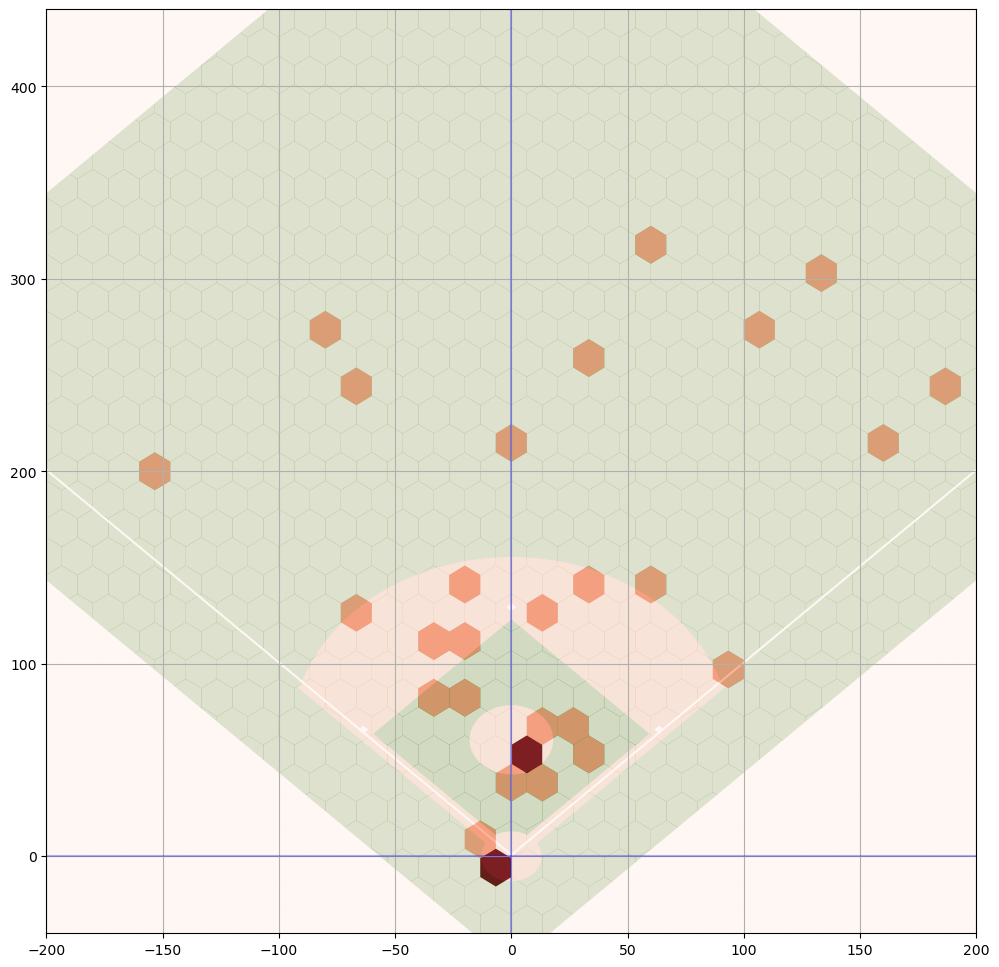

In [70]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()
#f, a = plt.subplots()

#bf.ax.plot(throws["thrower_x"], throws["thrower_y"], "bo") 
#f, a = plt.subplots()

bf.ax.hexbin(throws["thrower_x"], 
             throws["thrower_y"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()



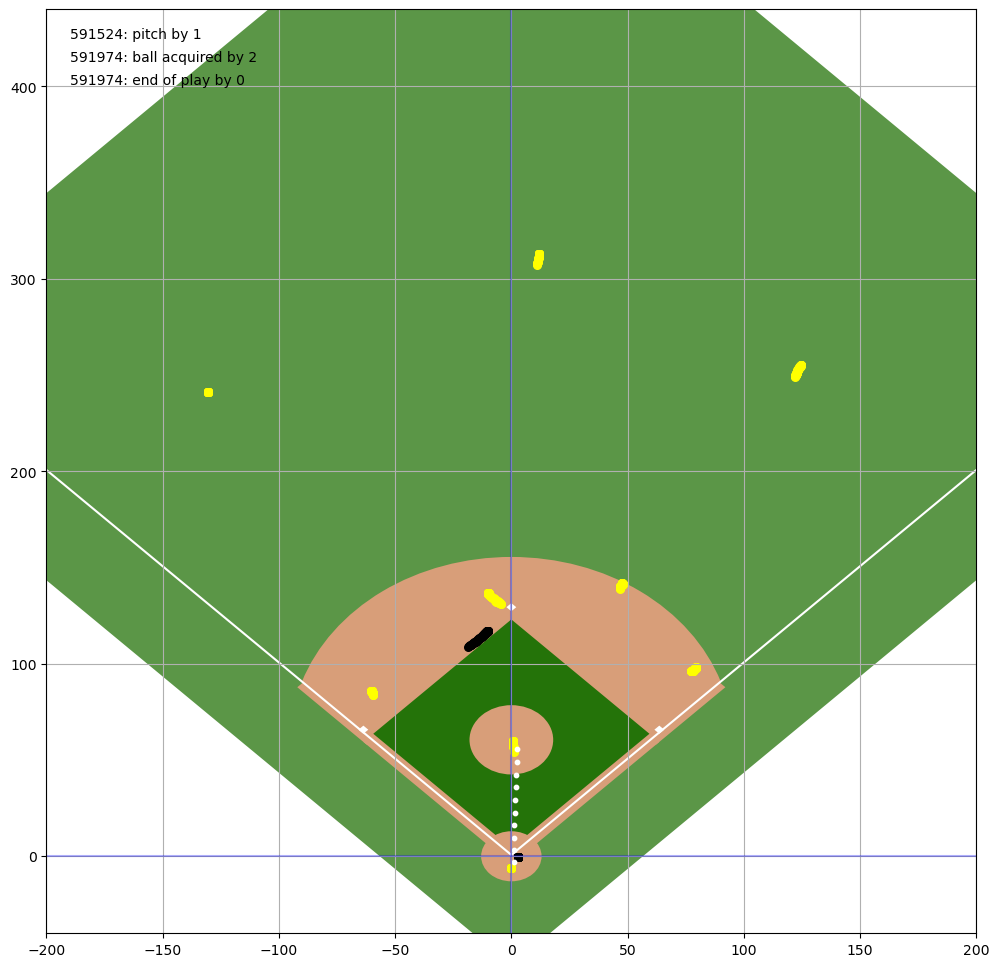

In [ ]:
bf.clear_plot()

play_id = 21# throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf.plot_all_components(play_id=play_id)
bf.fig

# bf.create_gif(play_id=play_id, tag="--throw_to_end_play")

## Create some features
- xy_angle
- elevation_angle
- velo
- x pos
- y pos
- runner dist to first at throw
- (runner speed?) maybe redundent?


## Try to build a Logistic Regression Model 

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression